In [75]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras import layers, models

from skimage.transform import resize

import matplotlib.pyplot as plt
import csv

import random

import os

import pandas as pd
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


## Steuerungs-Parameter

In [2]:
#Parameter

#Speicherort der Test-Daten for example './GTSRB/Training'
TRAINING_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images" #"C:/Users/de136581/Documents/Uni/SoSe_2024/DSKI_Projekt/Data_trafic_Signs/Final_Training/GTSRB/Final_Training/Images" 

TEST_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Online-Test-Images/GTSRB/Online-Test/Images"

## Allgemeine Funktionen

In [3]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def format_imgs(imgs_lst):
    new_size = (32, 32)
    resized_images = []
    for img in imgs_lst:
        resized_img = resize(img, new_size, anti_aliasing=True)
        resized_images.append(resized_img)

    return np.array(resized_images)

In [13]:
# Mapper Funktion Klassennummer - Verkehrszeichen
def get_traffic_sign_name(class_id):
    # Dictionary that maps class IDs to traffic sign names in German
    class_id_to_name = {
        0: "Geschwindigkeitsbegrenzung (20km/h)",
        1: "Geschwindigkeitsbegrenzung (30km/h)",
        2: "Geschwindigkeitsbegrenzung (50km/h)",
        3: "Geschwindigkeitsbegrenzung (60km/h)",
        4: "Geschwindigkeitsbegrenzung (70km/h)",
        5: "Geschwindigkeitsbegrenzung (80km/h)",
        6: "Ende der Geschwindigkeitsbegrenzung (80km/h)",
        7: "Geschwindigkeitsbegrenzung (100km/h)",
        8: "Geschwindigkeitsbegrenzung (120km/h)",
        9: "Überholverbot",
        10: "Überholverbot für Fahrzeuge über 3,5 Tonnen",
        11: "Vorfahrt an der nächsten Kreuzung",
        12: "Vorfahrtstraße",
        13: "Vorfahrt gewähren",
        14: "Halt",
        15: "Verbot für Fahrzeuge",
        16: "Verbot für Fahrzeuge über 3,5 Tonnen",
        17: "Einfahrt verboten",
        18: "Allgemeine Gefahr",
        19: "Gefährliche Kurve nach links",
        20: "Gefährliche Kurve nach rechts",
        21: "Doppelkurve",
        22: "Unebene Fahrbahn",
        23: "Schleudergefahr bei Nässe oder Schmutz",
        24: "Fahrbahnverengung",
        25: "Baustelle",
        26: "Ampel",
        27: "Fußgänger",
        28: "Kinder",
        29: "Radfahrer",
        30: "Schnee- oder Eisglätte",
        31: "Wildwechsel",
        32: "Ende aller Streckenverbote",
        33: "Rechts abbiegen",
        34: "Links abbiegen",
        35: "Geradeaus",
        36: "Geradeaus oder rechts",
        37: "Geradeaus oder links",
        38: "Rechts vorbei",
        39: "Links vorbei",
        40: "Kreisverkehr",
        41: "Ende des Überholverbots",
        42: "Ende des Überholverbots für Fahrzeuge über 3,5 Tonnen"
    }
    
    # Return the name of the traffic sign corresponding to the given class ID
    return class_id_to_name.get(class_id, "Unbekannte Klassennummer")

### Dateneinlesen

für alle Klassifizierungen

In [36]:
# Trainings und Testdaten vorbereiten
trainImages, trainLabels =  readTrafficSigns(TRAINING_DATA_PATH)

## Binäre Klassifikation

In [40]:
bin_labels = np.where( np.array(trainLabels) == 1, 1, 0)
# Train-Test-Aufteilung
bin_img_train, bin_img_test, bin_labels_train, bin_labels_test = train_test_split(trainImages,  bin_labels, test_size=0.2, random_state=42)

# Daten normalisieren
bin_img_train = format_imgs(bin_img_train) / 255
bin_img_test = format_imgs(bin_img_test) / 255

# Labels zu kategorischen Daten umwandeln
bin_labels_train = to_categorical(bin_labels_train, 2)
bin_labels_test = to_categorical(bin_labels_test, 2)

In [46]:
# CNN-Modell erstellen
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
bin_history = model.fit(bin_img_train, bin_labels_train, epochs=10, validation_data=(bin_img_test, bin_labels_test), batch_size=32)

### Gütemaß Genauigkeit (Accuracy)

**Beachte:** Die Genauigkeit gibt an, wie groß der Anteil aller von einem Klassifikator korrekt bewerteten Objekte an der Gesamtheit aller Objekte ist.

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 7.3262e-17
Validation accuracy: 1.0


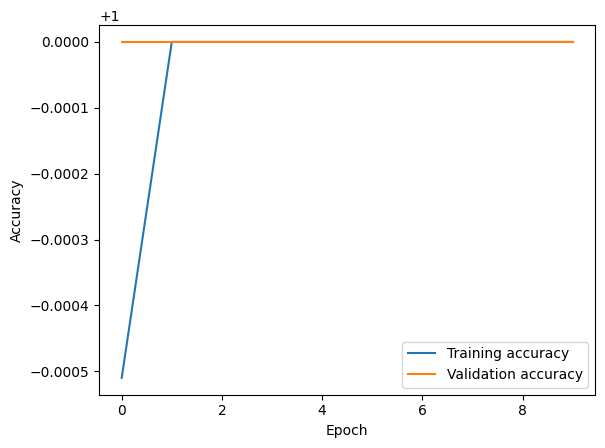

In [49]:
# Modellbewertung
val_loss, val_acc = model.evaluate(bin_img_test, bin_labels_test)
print(f'Validation accuracy: {val_acc}')

# Plotten der Trainingsgeschichte
import matplotlib.pyplot as plt

plt.plot(bin_history.history['accuracy'], label='Training accuracy')
plt.plot(bin_history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## CNN Multiclass

In [50]:
# Train-Test-Aufteilung
img_train, img_test, labels_train, labels_test = train_test_split(trainImages,  trainLabels, test_size=0.2, random_state=42)
# One-Hot-Encoding der Labels
labels_train = to_categorical(labels_train, 43)
labels_test = to_categorical(labels_test, 43)

img_train = format_imgs(img_train)
img_test = format_imgs(img_test)

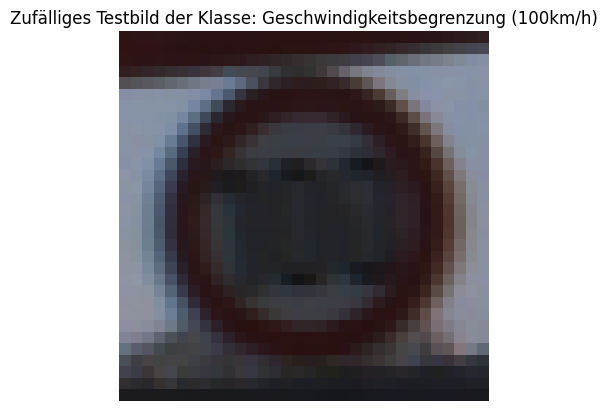

In [51]:
# Wähle ein zufälliges Bild aus dem Trainingsdatensatz
random_index = np.random.randint(0, len(img_train))
bsp_image = img_train[random_index]
bsp_label = labels_train[random_index]

# Zeige das Bild an
plt.imshow(bsp_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild der Klasse: {get_traffic_sign_name(np.argmax(bsp_label))}")
plt.axis('off')
plt.show()

In [52]:
# Modellarchitektur
# Definiere das Modell
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))  # 43 Klassen für Verkehrszeichen

# Kompiliere das Modell
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
history = model.fit(img_train, labels_train, epochs=10, batch_size=32, validation_data=(img_test, labels_test)) #, validation_data=(img_test, labels_test)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9934 - loss: 0.0255 - val_accuracy: 0.9792 - val_loss: 0.1060
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9941 - loss: 0.0254 - val_accuracy: 0.9809 - val_loss: 0.1042
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9953 - loss: 0.0167 - val_accuracy: 0.9770 - val_loss: 0.1217
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9949 - loss: 0.0212 - val_accuracy: 0.9699 - val_loss: 0.1495
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9961 - loss: 0.0168 - val_accuracy: 0.9833 - val_loss: 0.0987
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9976 - loss: 0.0097 - val_accuracy: 0.9685 - val_loss: 0.1613
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9936 - loss: 0.0241 - val_accuracy: 0.9834 - val_loss: 0.0962
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9982 - loss: 0.0076 - 

### Modell-Evaluation

... hier noch verschiedene Gütemaße und Wahrheitsmatrix

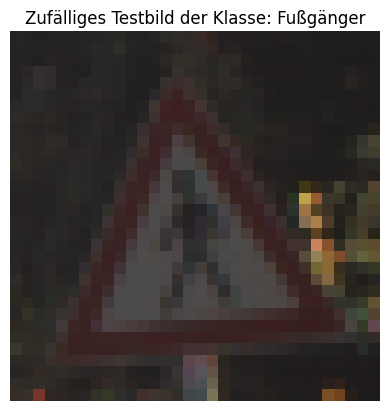

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Vorhergesagte Klasse: Fußgänger
Wahrscheinlichkeit: 0.99


In [59]:
#Testen des Modells:
    
# Wähle ein zufälliges Bild aus dem Testdatensatz
random_index = np.random.randint(0, len(img_test))
test_image = img_test[random_index]
true_label = labels_test[random_index]

# Zeige das Bild an
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild der Klasse: {get_traffic_sign_name(np.argmax(true_label))}")
plt.axis('off')
plt.show()

# Klassifiziere das Bild mit dem trainierten Modell
predicted_probs = model.predict(np.expand_dims(test_image, axis=0))
predicted_class = np.argmax(predicted_probs)

# Gib die Klassifizierung und die Wahrscheinlichkeit aus
print(f"Vorhergesagte Klasse: {get_traffic_sign_name(np.argmax(true_label))}")
print(f"Wahrscheinlichkeit: {predicted_probs[0][predicted_class]:.2f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9768 - loss: 0.1406
Validation accuracy: 0.9783218502998352


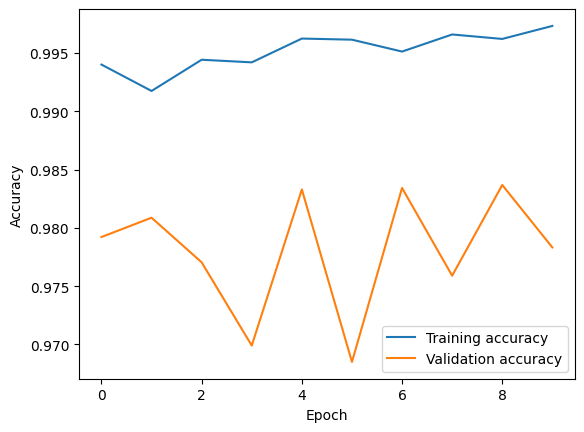

In [60]:
# Modellbewertung
val_loss, val_acc = model.evaluate(img_test, labels_test)
print(f'Validation accuracy: {val_acc}')

# Plotten der Trainingsgeschichte
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Eine Confusion Matrix (Verwechslungsmatrix) ist ein Performance-Maß für maschinelle Lernmodelle, insbesondere für Klassifikationsprobleme. Sie ermöglicht eine detaillierte Analyse der Klassifikationsgenauigkeit, indem sie die tatsächlichen Labels (Wahrheiten) den vorhergesagten Labels (Vorhersagen) gegenüberstellt. Eine Confusion Matrix ist eine tabellarische Darstellung, die wie folgt aussieht:

Predicted: Class 1	Predicted: Class 2	...	Predicted: Class N
Actual: Class 1	True Positive (TP)	False Negative (FN)	...	False Negative (FN)
Actual: Class 2	False Positive (FP)	True Positive (TP)	...	False Negative (FN)
...	...	...	...	...
Actual: Class N	False Positive (FP)	False Positive (FP)	...	True Positive (TP)
True Positives (TP): Die Anzahl der korrekt als positive Klasse vorhergesagten Instanzen.
False Positives (FP): Die Anzahl der fälschlicherweise als positive Klasse vorhergesagten Instanzen.
False Negatives (FN): Die Anzahl der fälschlicherweise als negative Klasse vorhergesagten Instanzen.
True Negatives (TN): Die Anzahl der korrekt als negative Klasse vorhergesagten Instanzen (in der obigen Matrix nicht dargestellt, da sie sich auf alle anderen Klassen außerhalb der aktuellen Fokusklasse bezieht).
Die Confusion Matrix hilft dabei, verschiedene Leistungsmetriken zu berechnen, wie z.B.:

Accuracy (Genauigkeit): Der Anteil der korrekt vorhergesagten Instanzen.
Precision (Präzision): Der Anteil der korrekt vorhergesagten positiven Instanzen.
Recall (Empfindlichkeit): Der Anteil der tatsächlichen positiven Instanzen, die korrekt vorhergesagt wurden.
F1-Score: Der harmonische Mittelwert von Precision und Recall.

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


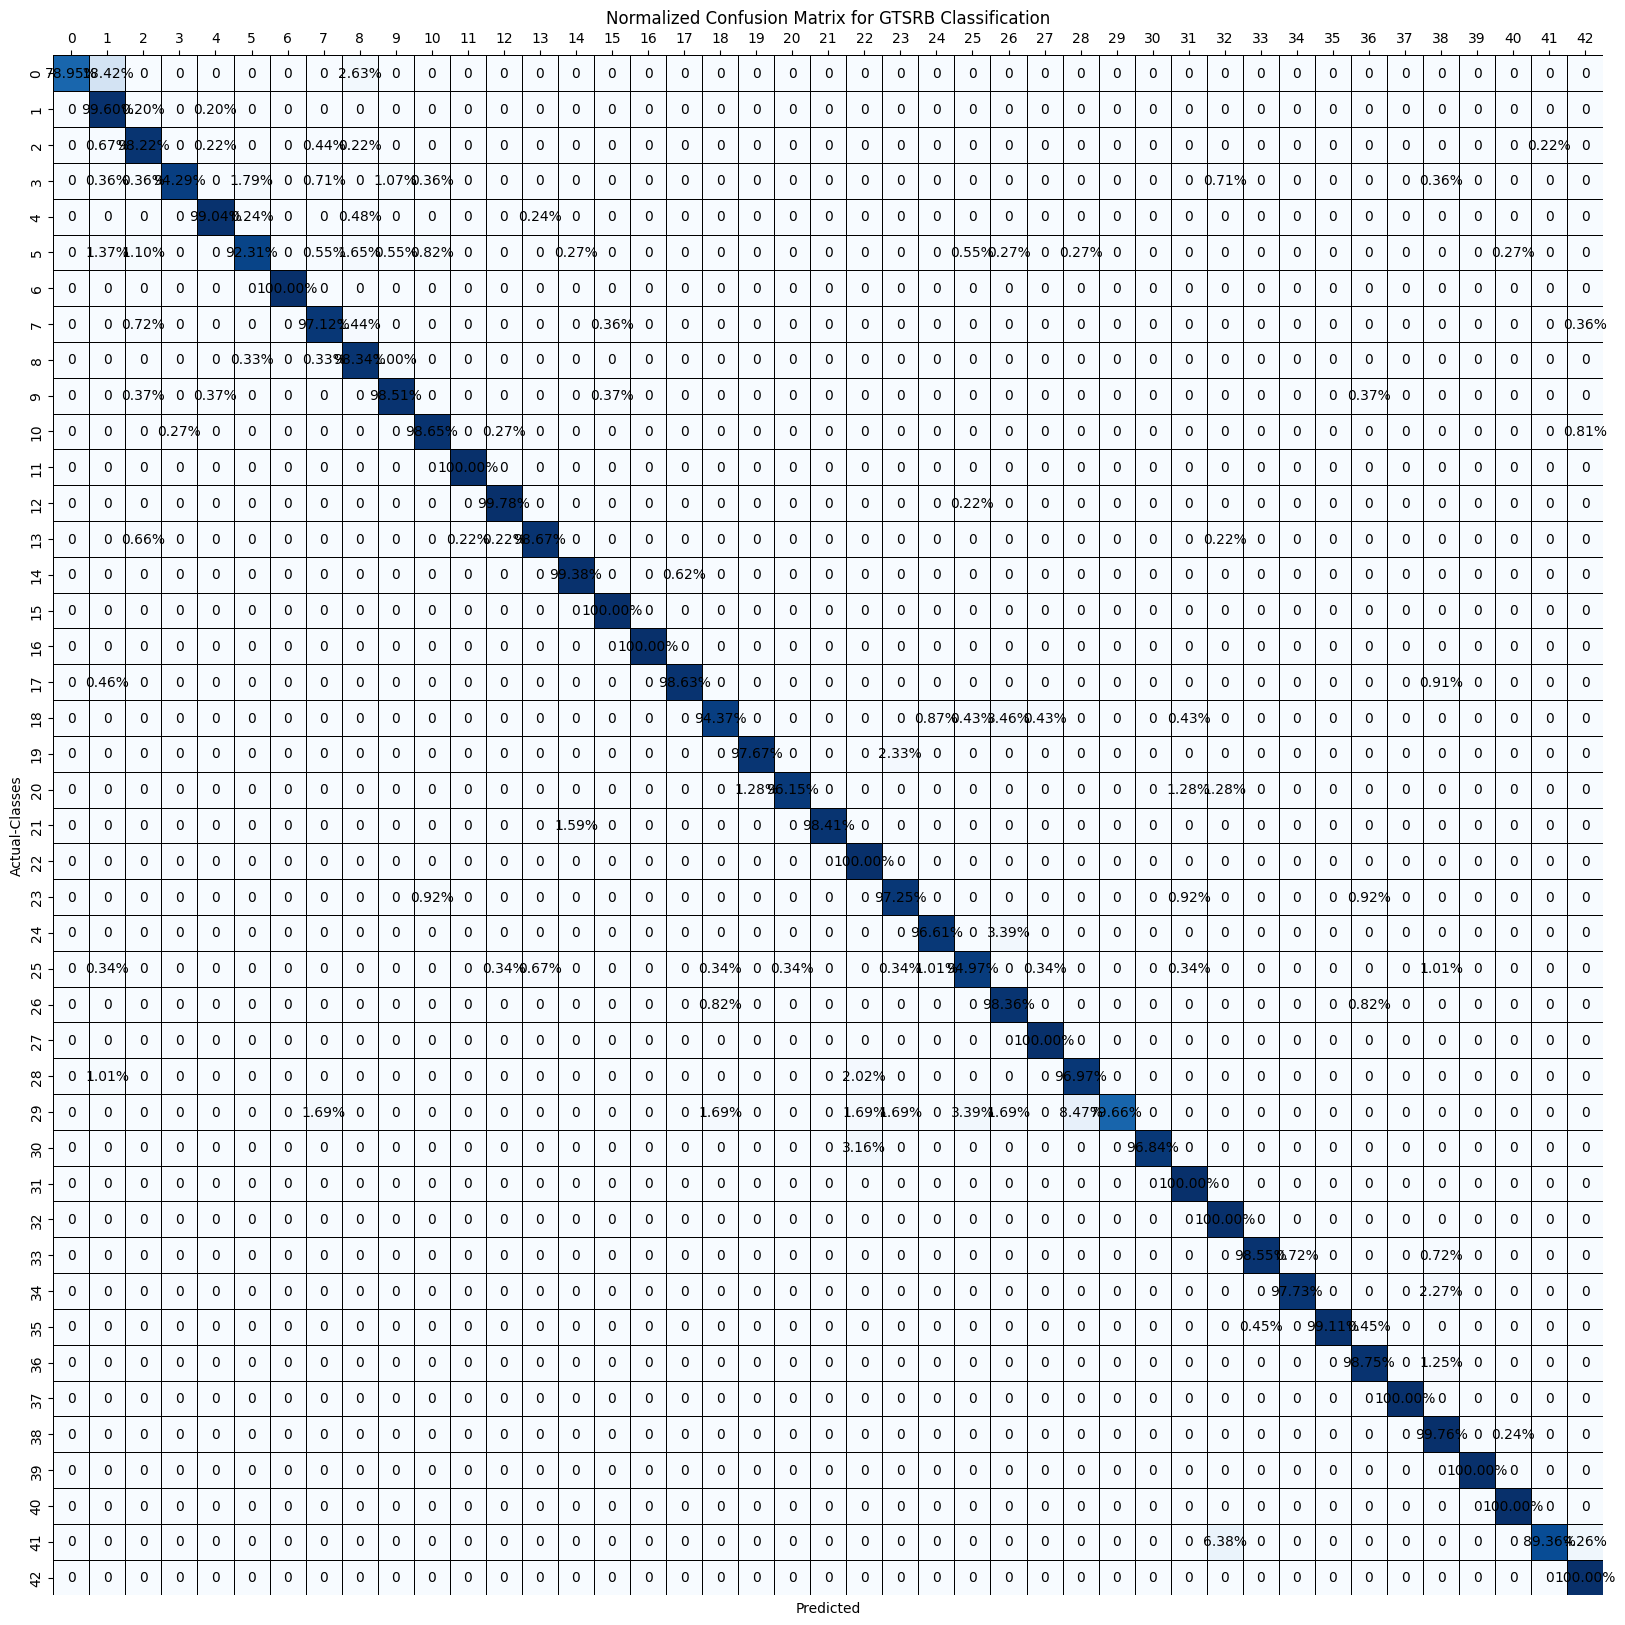

In [86]:
# Vorhersagen für die Testdaten
y_pred = model.predict(img_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)

# Confusion Matrix berechnen
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix normalisieren
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Replace NaNs with 0

# Funktion zum Formatieren der Werte
def format_func(value):
    if value == 0:
        return '0'
    elif value < 0.0001:  # Wert < 0.01%
        return ''
    else:
        return f'{value:.2%}'

# Confusion Matrix visualisieren
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_normalized, fmt='', cmap='Blues', xticklabels=range(43), yticklabels=range(43),
            annot_kws={"size": 7}, cbar=False, linewidths=.5, linecolor='black')

# Set custom annotations
for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        plt.text(j + 0.5, i + 0.5, format_func(conf_matrix_normalized[i, j]),
                 horizontalalignment='center', verticalalignment='center')

plt.xlabel('Predicted')

# X-Achse am oberen Rand platzieren
plt.gca().xaxis.set_ticks_position('top')
plt.ylabel('Actual-Classes')
plt.title('Normalized Confusion Matrix for GTSRB Classification')
plt.show()

In [ ]:
# Confusion Matrix visualisieren
plt.figure(figsize=(25, 25))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', xticklabels=range(43), yticklabels=range(43)) #, fmt='.2%'
plt.xlabel('Predicted')
plt.ylabel('Actual-Class')
plt.title('Normalized Confusion Matrix for GTSRB Classification')
plt.show()

# Zusätzliche Metriken ausgeben
print(classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(43)]))

Neben der Confusion Matrix gibt es mehrere wichtige Gütemaße zur Bewertung der Leistung eines Klassifikationsmodells:

Precision (Präzision):

Definition: 
Precision
=
True Positives (TP)
True Positives (TP)
+
False Positives (FP)
Precision= 
True Positives (TP)+False Positives (FP)
True Positives (TP)
​
 
Bedeutung: Der Anteil der tatsächlich korrekten positiven Vorhersagen an allen positiven Vorhersagen. Eine hohe Präzision bedeutet, dass wenige falsch-positive Ergebnisse (Fehlalarme) vorliegen.
Recall (Empfindlichkeit):

Definition: 
Recall
=
True Positives (TP)
True Positives (TP)
+
False Negatives (FN)
Recall= 
True Positives (TP)+False Negatives (FN)
True Positives (TP)
​
 
Bedeutung: Der Anteil der tatsächlichen positiven Fälle, die korrekt identifiziert wurden. Ein hoher Recall bedeutet, dass wenige tatsächliche positive Fälle übersehen werden.
F1-Score:

Definition: 
F1-Score
=
2
×
Precision
×
Recall
Precision
+
Recall
F1-Score=2× 
Precision+Recall
Precision×Recall
​
 
Bedeutung: Der harmonische Mittelwert von Präzision und Recall. Er liefert ein ausgewogenes Maß, das beide Aspekte berücksichtigt.
Accuracy (Genauigkeit):

Definition: 
Accuracy
=
Anzahl der korrekten Vorhersagen
Gesamtzahl der Vorhersagen
Accuracy= 
Gesamtzahl der Vorhersagen
Anzahl der korrekten Vorhersagen
​
 
Bedeutung: Der Anteil der korrekten Vorhersagen an allen Vorhersagen. Er gibt die allgemeine Genauigkeit des Modells an.
Support:

Bedeutung: Die Anzahl der wahren Instanzen pro Klasse im Testdatensatz.
Diese Metriken können sowohl für jede Klasse einzeln als auch für das gesamte Modell berechnet werden. Für das gesamte Modell sind insbesondere die folgenden Metriken von Interesse:

Macro-Averaged Precision, Recall und F1-Score: Der Durchschnitt dieser Metriken über alle Klassen hinweg, unabhängig von der Anzahl der Instanzen in jeder Klasse.
Weighted-Averaged Precision, Recall und F1-Score: Der Durchschnitt dieser Metriken über alle Klassen hinweg, gewichtet nach der Anzahl der Instanzen in jeder Klasse.

In [76]:

# Zusätzliche Metriken ausgeben
report = classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(43)])
print(report)

# Gütemaße für das gesamte Modell berechnen und ausgeben
accuracy = accuracy_score(y_true, y_pred_classes)
macro_precision = precision_score(y_true, y_pred_classes, average='macro')
macro_recall = recall_score(y_true, y_pred_classes, average='macro')
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')
weighted_precision = precision_score(y_true, y_pred_classes, average='weighted')
weighted_recall = recall_score(y_true, y_pred_classes, average='weighted')
weighted_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Macro-Averaged Precision: {macro_precision:.4f}')
print(f'Macro-Averaged Recall: {macro_recall:.4f}')
print(f'Macro-Averaged F1 Score: {macro_f1:.4f}')
print(f'Weighted-Averaged Precision: {weighted_precision:.4f}')
print(f'Weighted-Averaged Recall: {weighted_recall:.4f}')
print(f'Weighted-Averaged F1 Score: {weighted_f1:.4f}')

              precision    recall  f1-score   support

     Class 0       1.00      0.79      0.88        38
     Class 1       0.96      1.00      0.98       496
     Class 2       0.97      0.98      0.98       450
     Class 3       1.00      0.94      0.97       280
     Class 4       0.99      0.99      0.99       418
     Class 5       0.98      0.92      0.95       364
     Class 6       1.00      1.00      1.00        59
     Class 7       0.97      0.97      0.97       278
     Class 8       0.95      0.98      0.97       301
     Class 9       0.97      0.99      0.98       268
    Class 10       0.99      0.99      0.99       370
    Class 11       1.00      1.00      1.00       236
    Class 12       0.99      1.00      1.00       450
    Class 13       0.99      0.99      0.99       452
    Class 14       0.99      0.99      0.99       162
    Class 15       0.98      1.00      0.99       120
    Class 16       1.00      1.00      1.00        90
    Class 17       1.00    

## SVM als Klassifizierer

In [4]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Trainings und Testdaten vorbereiten
trainImages, trainLabels =  readTrafficSigns(TRAINING_DATA_PATH)

In [6]:
images = format_imgs(trainImages)

In [7]:
labels = trainLabels

In [8]:
# Überprüfen, ob alle Bilder die gleiche Größe haben
print("Bildgröße:", np.array(images).shape)  # Sollte (Anzahl_Bilder, 32, 32) sein

# Daten normalisieren und in das richtige Format bringen
X = np.array(images).reshape(len(images), -1) / 255.0
y = np.array(labels)

Bildgröße: (39209, 32, 32, 3)


In [9]:
# Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# SVM Modell erstellen
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [11]:
# Trainingszeit messen
import time
start_time = time.time()

svm_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Trainingszeit: {training_time:.2f} Sekunden")

Trainingszeit: 3909.09 Sekunden


In [12]:
# Vorhersagen auf den Testdaten
y_pred = svm_model.predict(X_test)

# Genauigkeit berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f'Genauigkeit: {accuracy * 100:.2f}%')

# Klassifikationsbericht anzeigen
print(classification_report(y_test, y_pred))

Genauigkeit: 13.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.18      0.33      0.24       496
          10       0.07      0.81      0.14       370
          11       0.00      0.00      0.00       236
          12       0.88      0.03      0.06       450
          13       0.39      0.30      0.34       452
          14       0.00      0.00      0.00       162
          15       0.00      0.00      0.00       120
          16       0.00      0.00      0.00        90
          17       0.00      0.00      0.00       219
          18       0.00      0.00      0.00       231
          19       0.00      0.00      0.00        43
           2       0.12      0.46      0.20       450
          20       0.00      0.00      0.00        78
          21       0.00      0.00      0.00        63
          22       0.00      0.00      0.00        86
          23       0.00      0.00      0.00       109
       

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Vergleich SVM vs CNN

... aufgreifen vorheriger Gütemaße und hier dann folgender Verglich von SVM und CNN